In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from nscl.models.embedding.attribute_embedding_space import *
from nscl.datasets.clevr_definition import *
from torch import optim

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# dimensions
input_dim = 64
output_dim = 8
all_shapes = CLEVRDefinition.attribute_concept_map['shape']

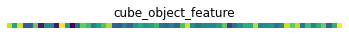

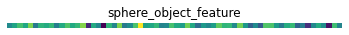

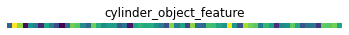

In [3]:
# Generate synthetic features
shape_features = {shape:torch.randn(input_dim) for shape in all_shapes}
for shape, features in shape_features.items():
    plt.figure()
    plt.axis("off")
    plt.title(f'{shape}_object_feature')
    plt.imshow(features.unsqueeze(1).t())

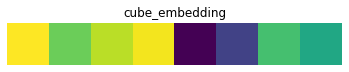

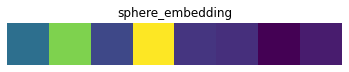

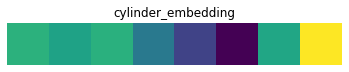

In [4]:
# Convert features to concept vectors
shape_of = nn.Linear(input_dim, output_dim)
shape_concepts = {shape:shape_of(shape_features[shape]).data for shape in all_shapes}

for shape, concept in shape_concepts.items():
    plt.figure()
    plt.axis("off")
    plt.title(f'{shape}_embedding')
    plt.imshow(concept.unsqueeze(1).t())

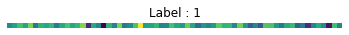

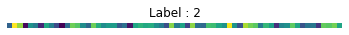

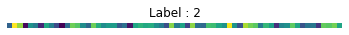

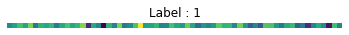

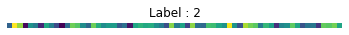

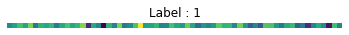

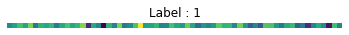

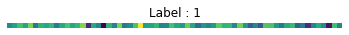

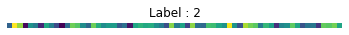

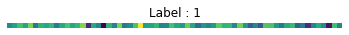

In [5]:
# Generate synthetic dataset
class EmbeddingDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return len(self.features)

num_data_per_shape = 100
shape_labels = {'cube':0, 'sphere':1, 'cylinder':2}
features = []
labels = []

for i in range(num_data_per_shape):
    for shape in all_shapes:
        features.append(shape_features[shape])
        labels.append(shape_labels[shape])

dataset = EmbeddingDataset(features, labels)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, drop_last=True)
for features, labels in dataloader:
    for i in range(len(features)):
        plt.figure()
        plt.axis("off")
        plt.title(f'Label : {labels[i].item()}')
        plt.imshow(features[i].unsqueeze(1).t())
    break


<bound method Module.parameters of AttributeEmbeddingSpace(
  (attribute_operators): Module(
    (shape): AttributeOperator(
      (map): Linear(in_features=64, out_features=8, bias=True)
    )
    (size): AttributeOperator(
      (map): Linear(in_features=64, out_features=8, bias=True)
    )
  )
  (concept_embeddings): Module(
    (cube): ConceptEmbedding()
    (sphere): ConceptEmbedding()
    (cylinder): ConceptEmbedding()
    (large): ConceptEmbedding()
    (small): ConceptEmbedding()
  )
)>


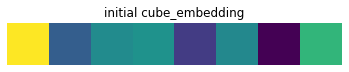

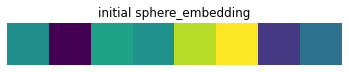

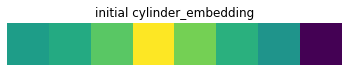

In [6]:
attribute_concept_map = {'shape':['cube', 'sphere', 'cylinder'], 'size':['large', 'small']}
embedding_space = AttributeEmbeddingSpace(attribute_concept_map, input_dim, output_dim)

print(embedding_space.parameters)

# initial shape embedding
for shape in all_shapes:
    plt.figure()
    plt.axis("off")
    plt.title(f'initial {shape}_embedding')
    plt.imshow(getattr(embedding_space.concept_embeddings, shape).concept_vector.data.unsqueeze(1).t())

In [7]:
objects = torch.stack([features[0], features[1]], dim=0)
print(objects.shape)
embedding_space.similarity(features[0], 'cube')

torch.Size([2, 64])
tensor(0.2151, grad_fn=<SigmoidBackward>)


tensor(0.2151, grad_fn=<SigmoidBackward>)

In [9]:
# Train embedding space
num_epoch = 10
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)
loss_function = nn.MSELoss()
optimiser = optim.SGD(embedding_space.parameters(), lr=0.01)

for i in range(num_epoch):
    for features, labels in dataloader:
        predicts = embedding_space.similarity(features, 'cube')


RuntimeError: The size of tensor a (16) must match the size of tensor b (2) at non-singleton dimension 1